## Uncertainty Forecasting with Quantile Deep Learning

In this notebook, we will **forecast future values** based on a synthetic time series dataset along with its **prediction forecast uncertainty**. Therefore, the notebook is divided in the following sections:

- [Introduction to Forecasting](#intro)
- [Forecast dataset: Time series](#time_series)
- [Forecast function: LSTM](#lstm)
- [Uncertainty Estimation: Quantile Deep Learning](#dqr)
- [Conclusions](#conclusions)

#### Imports and Utilities

In [ ]:
import sys

import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
tf.get_logger().setLevel('ERROR')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

mpl.rcParams['figure.figsize'] = 20, 10

from poc_forecasting_uncertainty.utils import time_series_utils

Using TensorFlow backend.


In [2]:
def plot_ts_forecast(ts_Y_train, ts_Y_test, q_yhat):
    forecast_h = len(q_yhat[0])
    train_window = len(ts_Y_train)
    x_length = forecast_h+train_window
    aa=[x for x in range(x_length)]
    plt.figure(figsize=(20,8))
    plt.plot(aa[:train_window], ts_Y_train, marker='.', label="train")
    plt.plot(aa[train_window:], ts_Y_test, marker='.', label="test")
    for i in range(0,len(QUANTILES)):
        plt.plot(aa[train_window:], q_yhat[i].reshape(-1), label="q_" + str(i) + "_pred")
    plt.tight_layout()
    plt.subplots_adjust(left=0.07)
    plt.xlabel('time step', size=15)
    plt.legend(fontsize=15)

#### Introduction to forecasting

<a id='intro'>Introduction to forecasting</a>

In forecasting, we *predict future observations* ${y_t}$  with a model ${\phi}$ fit on a historical or time series dataset $\boldsymbol{y}_{t-1} = (y_{t-1},y_{t-2},\dots,y_{t-10})'$

$$y_t = \phi(\boldsymbol{y}_{t-1}) + \varepsilon_t$$

#### Forecast dataset: Time series

<a id='time_series'>Time series</a>

Here, we will create a synthetic seasonal time series dataset of 20 days starting at t0='2016-01-01 00:00:00' and hourly resolution. Cycles have a period pattern of 14 hours. 
- *Train*: 15 days (converted to hours)
- *Test*: 5 days (converted to hours)

Finally, we will add some white noise constant in time 

In [3]:
# ------Time series
t0 = '2016-01-01 00:00:00'
freq = 'H'
num_ts = 1

# default - changed in each experiemnt to test different behaviors
noise_level = 0.05
period = 14

# train, test
total_days = 20
tseries_length = total_days * 24 # hourly freq
train_days = 15 * 24

In [4]:
time_series_df = time_series_utils.generate_synth_tseries(t0, tseries_length, num_ts, period, freq, noise_level)

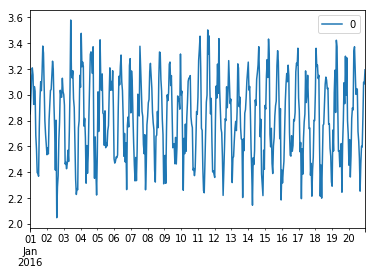

In [5]:
time_series_df.T.plot()

We split the time series dataset in **train and test**

In [6]:
train_ts = time_series_df.iloc[:, 0:train_days]
test_ts = time_series_df.iloc[:,train_days-1:-1]

In [7]:
train_ts.shape, test_ts.shape

((1, 360), (1, 120))

#### Forecasting function: LSTM

<a id='lstm'>Forecasting function: LSTM</a>

We will use a Univariate LSTM model ${\phi}$ for time series forecasting

The LSTM in contrast to traditional RNN uses memory cells to store, access and modify the internal state, allowing it to **better discover long-range temporal relationships**. These memory cells solve [vanishing gradient problem](#https://medium.com/datadriveninvestor/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577) present in RNN

In [8]:
# ------LSTM
features = 1 # We are working with univariate series so the number of features is 1
timesteps = 2 # we will work with a batch of 2 time steps

In [9]:
def lstm_model(X, ts_Y_train, n_steps, n_features):
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(timesteps, features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, ts_Y_train, epochs=200, verbose=0)
    return model

##### Data preparation

The split_sequence() function will split the univariate sequence into multiple samples where each sample has a specified number of time steps

In [10]:
ts_X_test, ts_Y_test = time_series_utils.split_sequence(test_ts.values[0], timesteps)
ts_X_train, ts_Y_train = time_series_utils.split_sequence(train_ts.values[0], timesteps)

# reshape X as input for the lstm [samples, timesteps, features]
X_train = ts_X_train.reshape((ts_X_train.shape[0], ts_X_train.shape[1], features)) 
X_test = ts_X_test.reshape((ts_X_test.shape[0], ts_X_test.shape[1], features)) 

In [11]:
X_test.shape, ts_Y_test.shape #  [samples, timesteps, features]

((118, 2, 1), (118,))

We have a forecasting horizon of 1 (t+1)

In [12]:
X_test[0:5], ts_Y_test[0:5]

(array([[[2.18487126],
         [2.41711209]],
 
        [[2.41711209],
         [2.31655861]],
 
        [[2.31655861],
         [2.41235366]],
 
        [[2.41235366],
         [2.48418511]],
 
        [[2.48418511],
         [2.70639282]]]),
 array([2.31655861, 2.41235366, 2.48418511, 2.70639282, 2.95107696]))

#### Uncertainty in forecasting

<a id='dqr'>Uncertainty in forecasting</a>

In order to estimate the uncertainty, we train the net with the title loss function to compute the quantiles

##### Independent Deep Quantile Regression

Fixed quantile bins τ0, …, τN -> N_taus

We fit N_taus indepent models for each quantile

In [13]:
# ----- Deep Quantile Regression
QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9] # N_taus
q = 0.5

Pasamos de estar aproximando la media condicionada de y, E[Y|X] con MSE a aproximar un cuantil (parte concreta de la distribucción de Y)

* ${\phi(x)}$ = y con MSE →  ${\phi(x)}$  = y con Pinball Loss


In [14]:
def tilted_loss(q, y, f):
    #e = (y - f)
    e = (f - y)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), axis=-1)

In [15]:
def lstm_dqr_model(X, ts_Y_train, n_steps, n_features, q):
    # define model
    model = tf.keras.Sequential()
    model.add(layers.LSTM(50, activation='relu', input_shape=(timesteps, features)))
    model.add(layers.Dense(1))
    model.compile(optimizer='adagrad', loss=lambda y, f: tilted_loss(q, y, f))
    # fit model
    model.fit(X, ts_Y_train, epochs=200, verbose=0)
    return model

In [16]:
q_models = []

for i in range(0,len(QUANTILES)):
    q_models.append(lstm_dqr_model(X_train, ts_Y_train, timesteps, features, QUANTILES[i]))

### Conclusions

<a id='conclusions'>Conclusions</a>

In [17]:
q_yhat = []

# predict each quantile of QUANTILES
for i in range(0,len(QUANTILES)):
    q_yhat.append(q_models[i].predict(X_test, verbose=0))

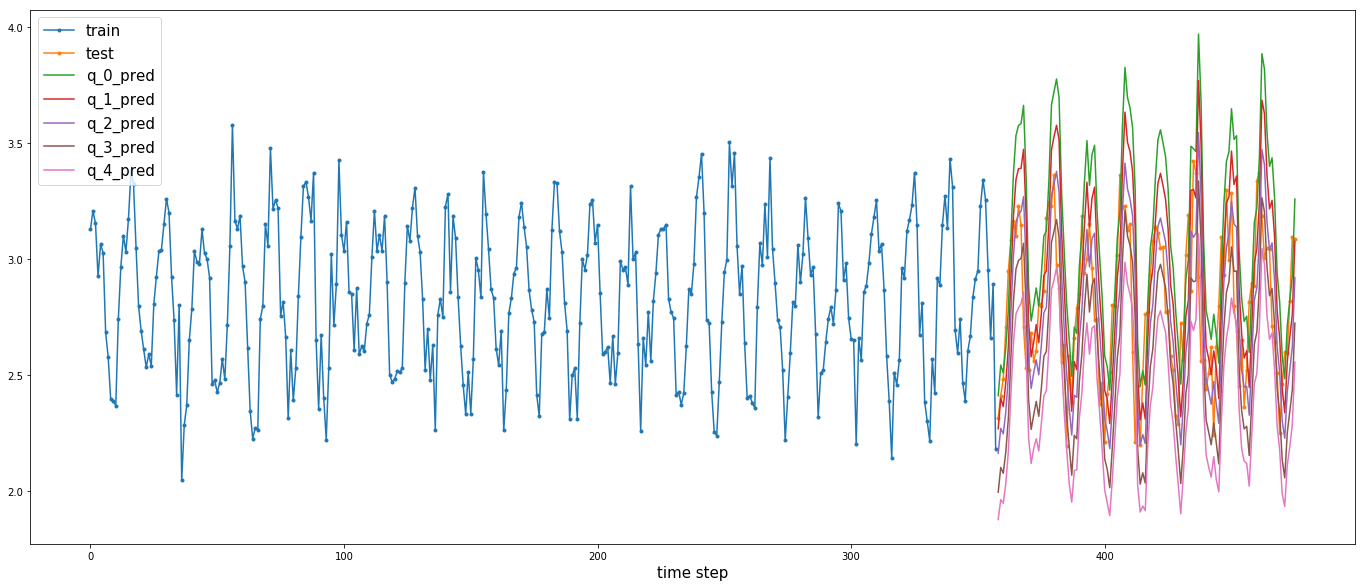

In [18]:
plot_ts_forecast(ts_Y_train, ts_Y_test, q_yhat)
plt.show()


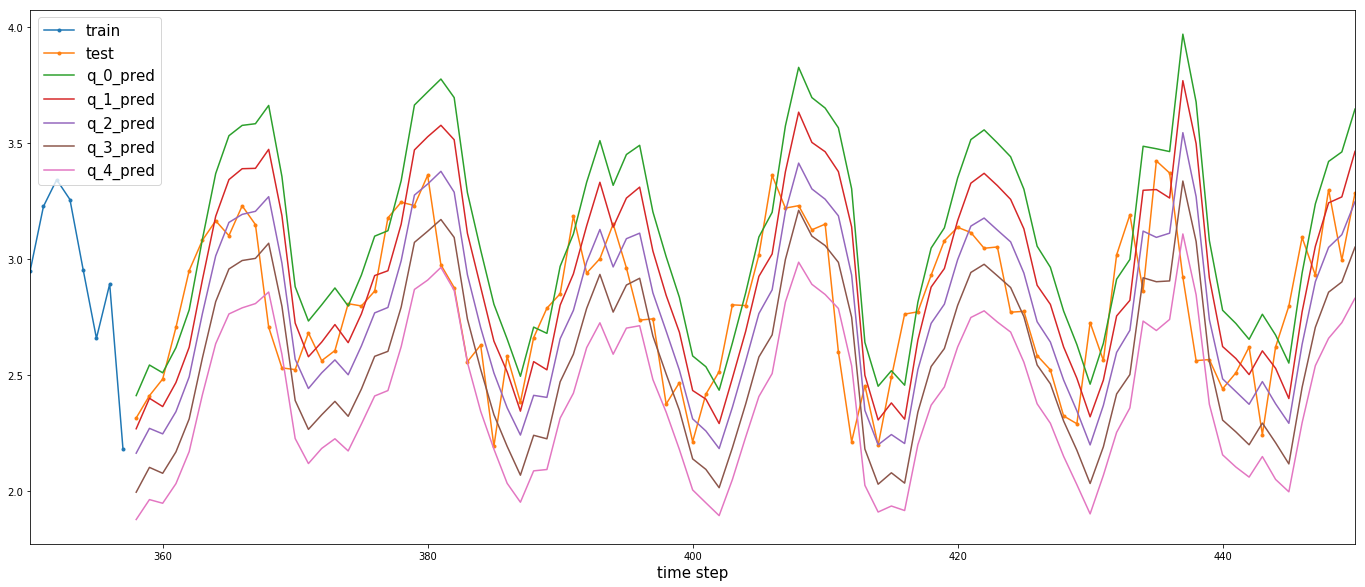

In [19]:
#QUANTILES = [0.1,0.5,0.9]
QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9]
plot_ts_forecast(ts_Y_train, ts_Y_test, q_yhat)
plt.xlim(350,450)
plt.show()

We obtain prediction intervals. The predictions of quantiles 2.5% and 97.5% cover the 95% of observations

Nevertheless, we observe that some quantile predictions are crossing, particuarly the ones in the middle.


*Disadvantages*:
 * It implies to adjust N indepent models
 * **Crossing quantile problem**: This will lead to misinterpretations 
     - Explanation of this problem to estimate a business metric used in finance [VaR](http://alfredgalichon.com/wp-content/uploads/2012/10/Galichon_slides.pdf)

##### Notebook References




- [1] https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- [2] https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
- [3] https://towardsdatascience.com/deep-quantile-regression-c85481548b5a

### Proximos Pasos

- **UMAL** [1]. Does UMAL solve the crossing quantile regression problem?
- **Deep Joint Quantile Regression** [2]. The method proposed here used a naive implementation that fits N models for each quantile. This is not efficient and for some problems it might be more interesting a joint estimation. In [2] it is explained the joint approach and how does it affect the quantile regression problem
    - Test the following hypothesis: Adding quantiles to the overall loss function adds relevant information about the target domain and can *induce a regularization effect*

- **Research**:
    - *How do we select a proper number of quantiles to be estimated?*
The ideal scenarios would be to keep only the most imformative quantiles while reducing the rest for each time step. This is related with entropy. Is there any existing method in the literature that explores this path? 



***Future steps References***

[1] Rodrigues, F., & Pereira, F. C. (2020). Beyond Expectation: Deep Joint Mean and Quantile Regression for Spatiotemporal Problems. IEEE Transactions on Neural Networks and Learning Systems, 1–13. https://doi.org/10.1109/tnnls.2020.2966745

[2] Brando, A., Rodríguez-Serrano, J. A., Vitrià, J., & Rubio, A. (2019). Modelling heterogeneous distributions with an Uncountable Mixture of Asymmetric Laplacians. (NeurIPS 2019). Retrieved from http://arxiv.org/abs/1910.12288

